<a href="https://colab.research.google.com/github/ds-anik/KAN-VAE/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install umap-learn

In [2]:
import time
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.distributions.normal import Normal
import torchvision.utils as vutils
from torchvision.utils import save_image
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap.umap_ as umap
import plotly.express as px
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Image Visualizations

In [4]:
def show_image(image, title='Sample Image'):
  '''
  show a single input image
  '''
  plt.figure(figsize=(1, 1))
  plt.imshow(image.permute(1, 2, 0).cpu().numpy().repeat(3, 2))
  plt.title(title)
  plt.axis('off')
  plt.show()

In [5]:
def show_images_grid(images, title='Sample Images Grid'):
  '''
  show input torch tensor of images [num_images, ch, w, h] in a grid
  '''
  # Add a channel dimension if it's missing
  if len(images.shape) == 3:  # [num_images, w, h]
      images = images.unsqueeze(1)  # Convert to [num_images, 1, w, h]

  plt.figure(figsize=(7, 7))
  grid = vutils.make_grid(images, nrow=images.shape[0]//2, padding=2, normalize=True)
  plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
  plt.title(title)
  plt.axis('off')
  plt.show()

#Downloading the dataset


In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [7]:
trainset = torchvision.datasets.MNIST(root='./data', train = True, download = True, transform = transform)
testset = torchvision.datasets.MNIST(root='./data', train = False, download = True, transform = transform)
xtrain = trainset.data.numpy()
ytrain = trainset.targets.numpy()
x_val_pre = testset.data[:1000].numpy()
y_val = testset.targets[:1000].numpy()

#Creating x_train and y_train with 1000 images from each class and binarizing the pixels


In [8]:
count = np.zeros(10)
idx = []
for i in range(0, len(ytrain)):
  for j in range(10):
    if(ytrain[i] == j):
      count[j] += 1
      if(count[j]<=1000):
        idx = np.append(idx, i)

y_train = ytrain[idx.astype('int')]
x_train_pre = xtrain[idx.astype('int')]

#Resizing the images


In [9]:
r,_,_ = x_train_pre.shape
x_train = np.zeros([r,28,28])
for i in range(r):
  a = cv2.resize(x_train_pre[i].astype('float32'), (28,28)) # Resizing the image from 28*28 to 14*14
  x_train[i] = a

r,_,_ = x_val_pre.shape
x_val = np.zeros([r,28,28])
for i in range(r):
  a = cv2.resize(x_val_pre[i].astype('float32'), (28,28)) # Resizing the image from 28*28 to 14*14
  x_val[i] = a

#Binarizing


In [10]:
x_train = np.where(x_train > 128, 1, 0)
x_val = np.where(x_val > 128, 1, 0)
x_train = x_train.astype(np.float32)
x_val = x_val.astype(np.float32)

#Creating dataloaders


In [11]:
batch_size = 32
trainloader = torch.utils.data.DataLoader([[x_train[i], y_train[i]] for i in range(len(y_train))], shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader([[x_val[i], y_val[i]] for i in range(len(y_val))], shuffle=True, batch_size=100)

#Variational Auto Encoder




In [12]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400) #Encoder
        self.fc21 = nn.Linear(400, 20) #mu
        self.fc22 = nn.Linear(400, 20) #sigma

        self.fc3 = nn.Linear(20, 400) #Decoder
        self.fc4 = nn.Linear(400, 784)

    def encoder(self, x):
        h = torch.tanh(self.fc1(x))
        return self.fc21(h), self.fc22(h) # mu, std

    def sampling(self, mu, std): # Reparameterization trick
        std = torch.exp(0.5*std)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decoder(self, z):
        h = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, std = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, std)
        return self.decoder(z), mu, std


model = VAE()
if torch.cuda.is_available():
    model.cuda()

#Defining loss, optimizer and LR scheduler


In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.5,
                             patience=5, threshold=0.001, cooldown=0,
                             min_lr=0.0001, verbose=True)

def loss_function(y, x, mu, std):
    ERR = F.binary_cross_entropy(y, x.view(-1, 784), reduction='sum')
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + std - mu.pow(2) - std.exp())
    #KLD = -0.5 * torch.sum(1 + torch.log(std**2) - mu**2 - std**2)
    return ERR + KLD, -ERR, -KLD

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


#Training and Validating


====> Epoch: 0 Average loss: -162.9273


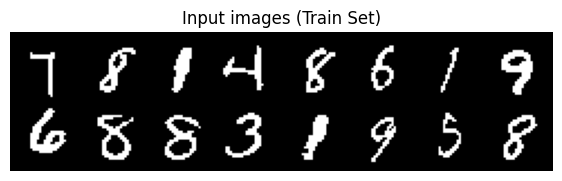

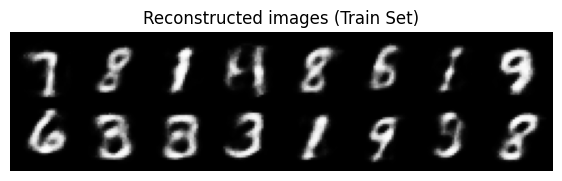

====> Test set loss: -130.0105


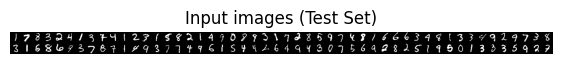

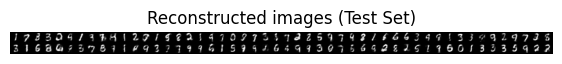

====> Epoch: 1 Average loss: -122.7843


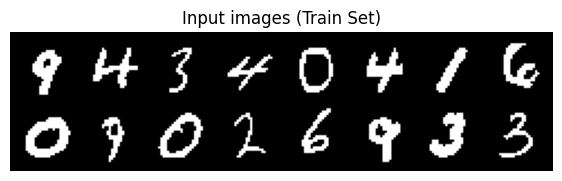

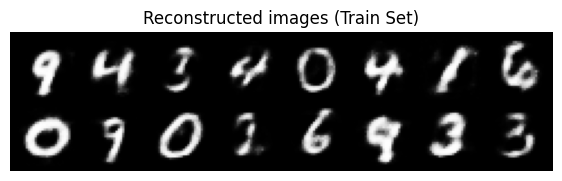

====> Test set loss: -119.2804


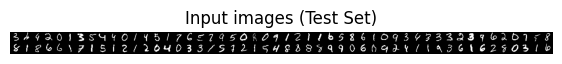

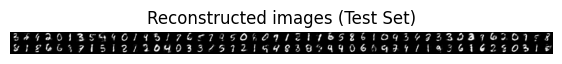

====> Epoch: 2 Average loss: -116.1793


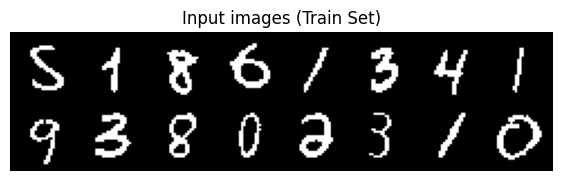

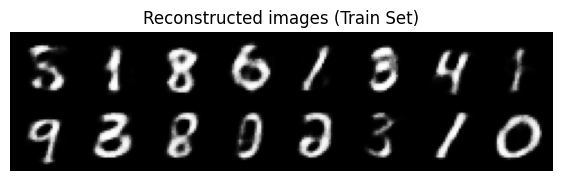

====> Test set loss: -113.7302


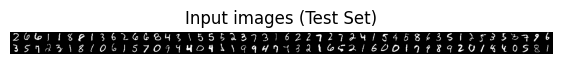

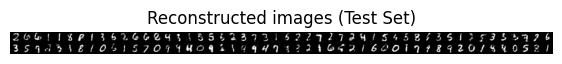

====> Epoch: 3 Average loss: -112.3904


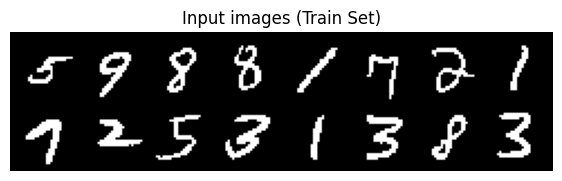

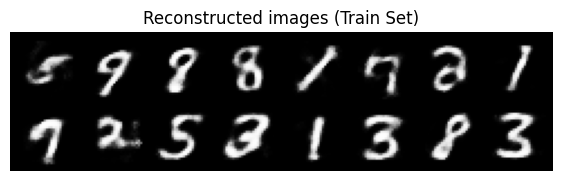

====> Test set loss: -113.0844


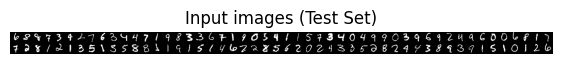

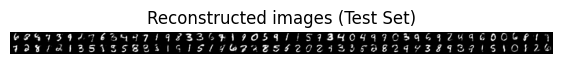

====> Epoch: 4 Average loss: -109.4140


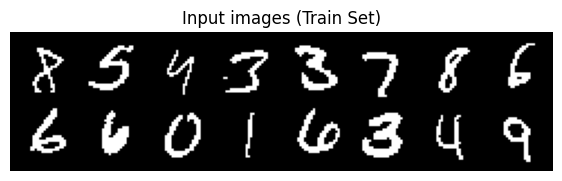

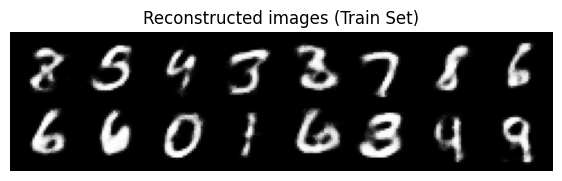

====> Test set loss: -110.1568


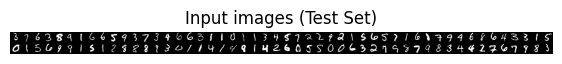

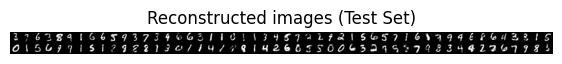

====> Epoch: 5 Average loss: -106.7300


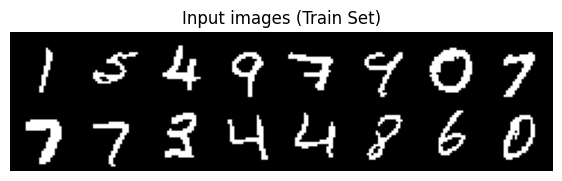

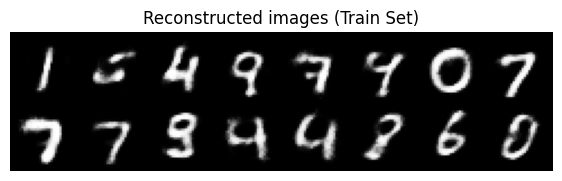

====> Test set loss: -107.5706


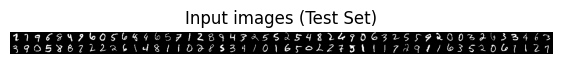

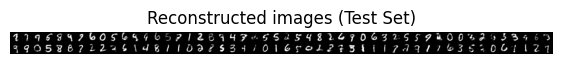

====> Epoch: 6 Average loss: -104.6326


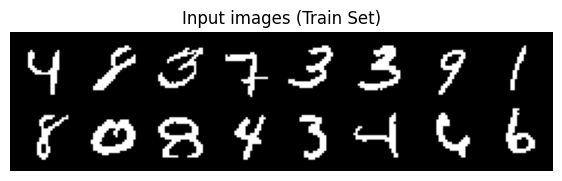

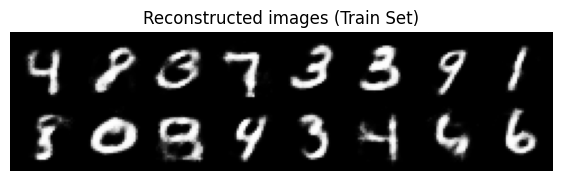

====> Test set loss: -106.5782


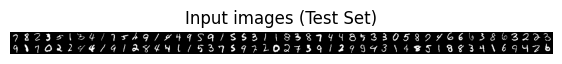

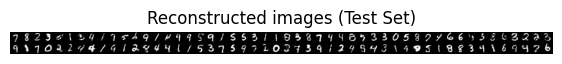

====> Epoch: 7 Average loss: -102.8897


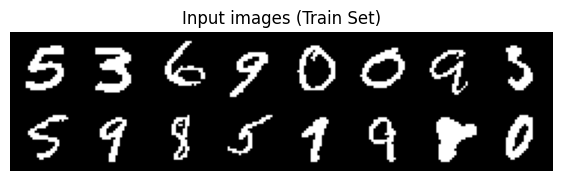

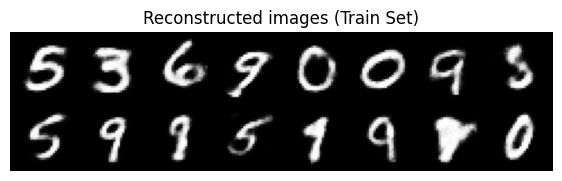

====> Test set loss: -105.2576


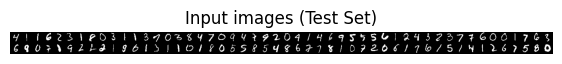

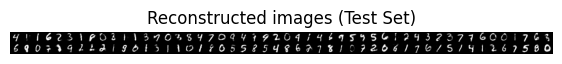

====> Epoch: 8 Average loss: -101.0997


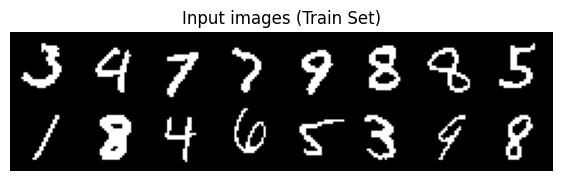

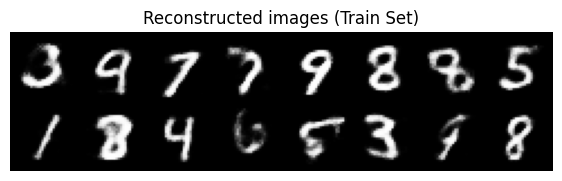

====> Test set loss: -105.3959


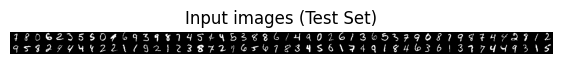

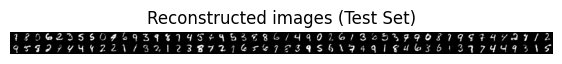

====> Epoch: 9 Average loss: -99.7502


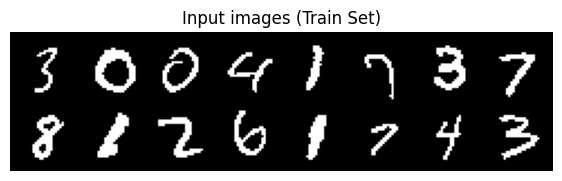

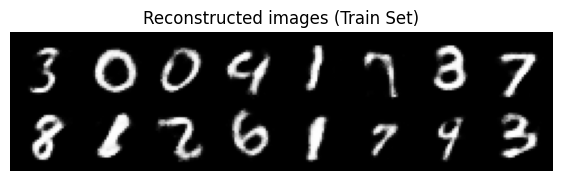

====> Test set loss: -105.3608


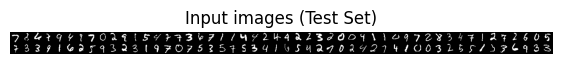

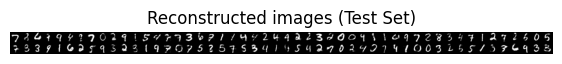

====> Epoch: 10 Average loss: -98.6268


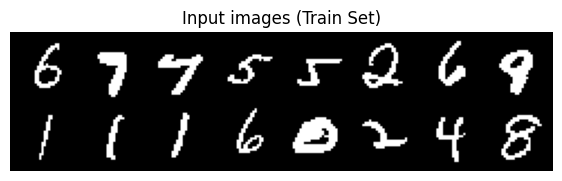

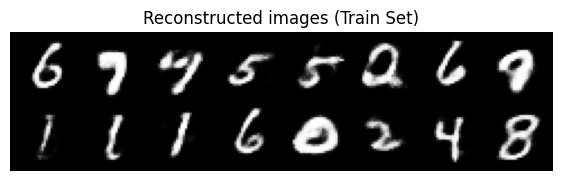

====> Test set loss: -102.5809


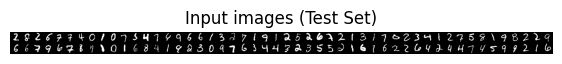

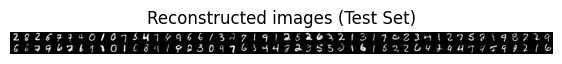

====> Epoch: 11 Average loss: -97.3600


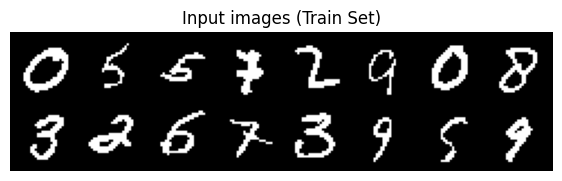

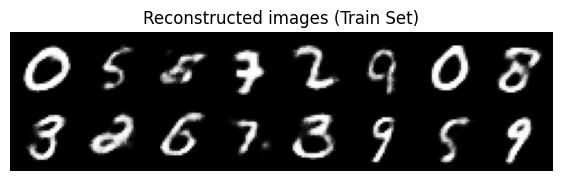

====> Test set loss: -101.8586


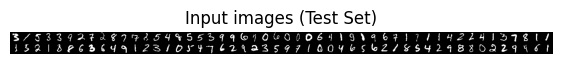

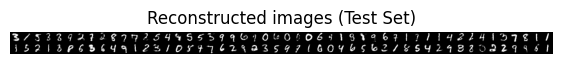

====> Epoch: 12 Average loss: -96.6278


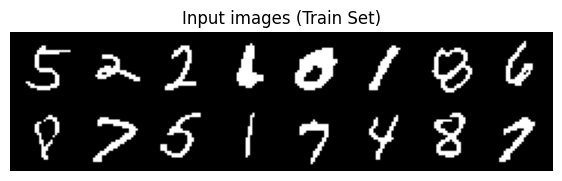

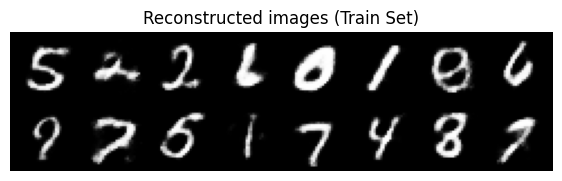

====> Test set loss: -103.0372


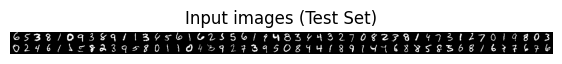

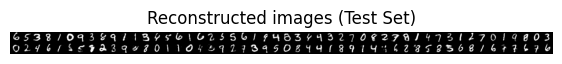

====> Epoch: 13 Average loss: -96.2352


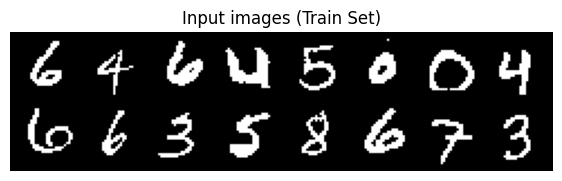

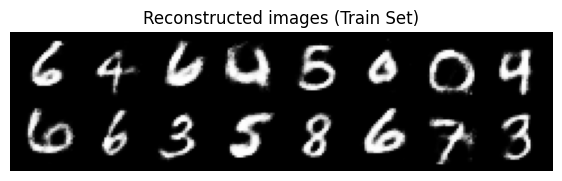

====> Test set loss: -101.3669


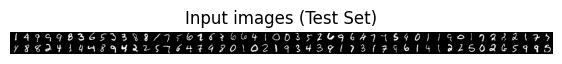

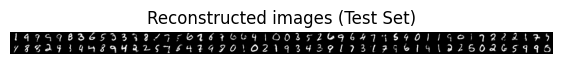

====> Epoch: 14 Average loss: -95.1363


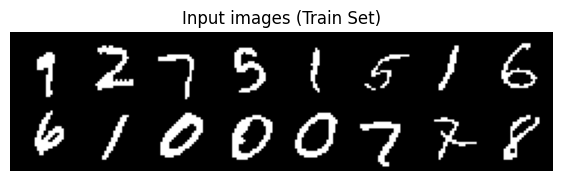

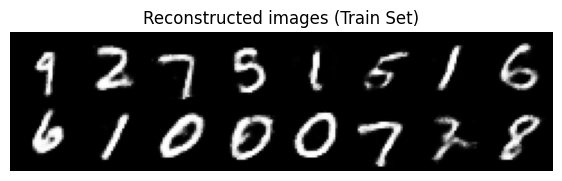

====> Test set loss: -100.0219


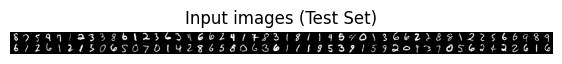

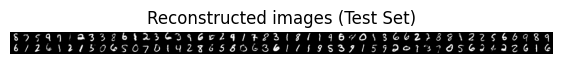

====> Epoch: 15 Average loss: -94.3621


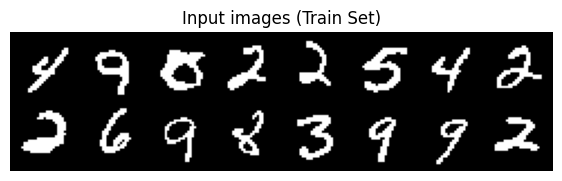

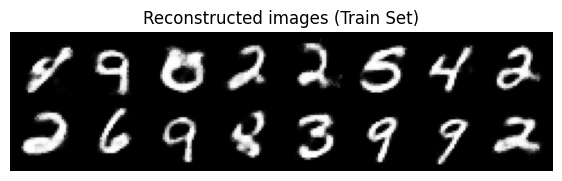

====> Test set loss: -99.9129


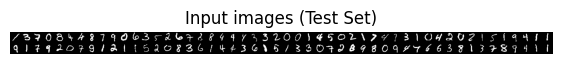

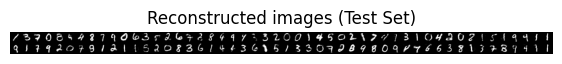

====> Epoch: 16 Average loss: -94.0785


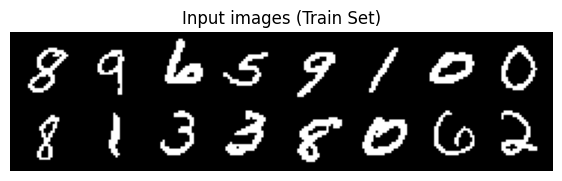

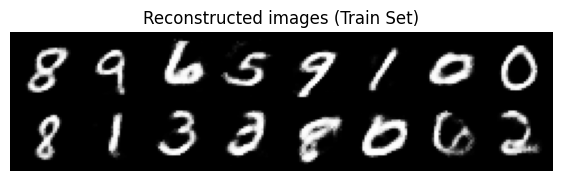

====> Test set loss: -101.2684


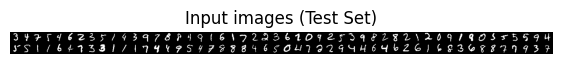

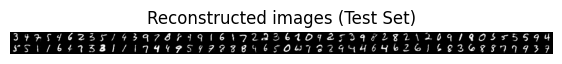

====> Epoch: 17 Average loss: -93.6040


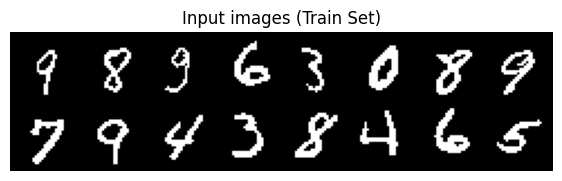

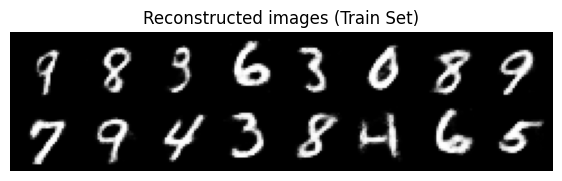

====> Test set loss: -102.1730


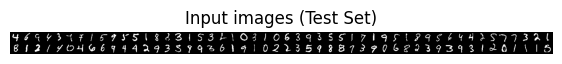

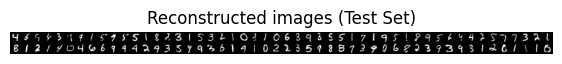

====> Epoch: 18 Average loss: -92.9403


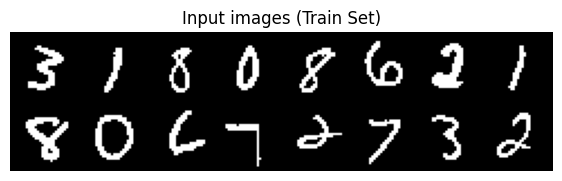

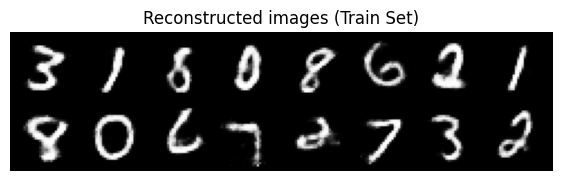

====> Test set loss: -100.6617


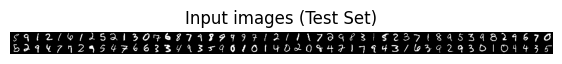

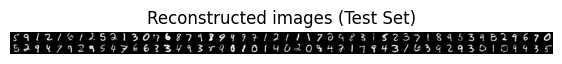

====> Epoch: 19 Average loss: -92.7295


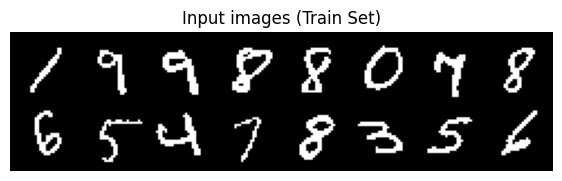

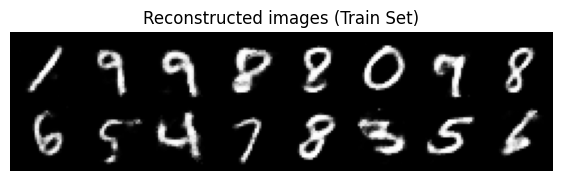

====> Test set loss: -99.9423


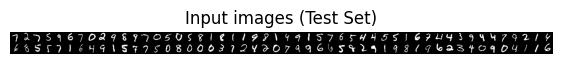

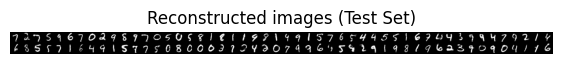

====> Epoch: 20 Average loss: -92.0375


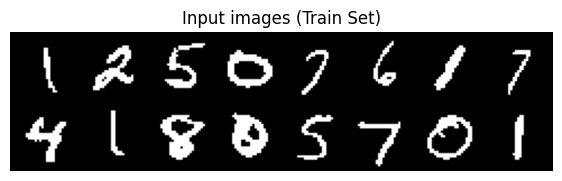

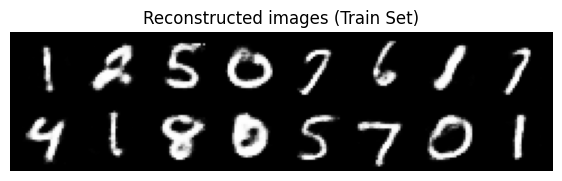

====> Test set loss: -99.7629


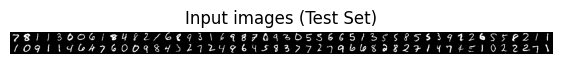

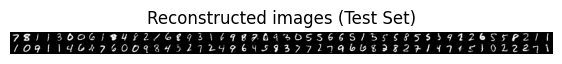

====> Epoch: 21 Average loss: -91.7700


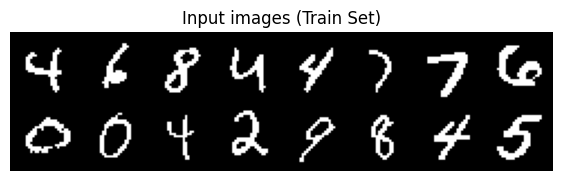

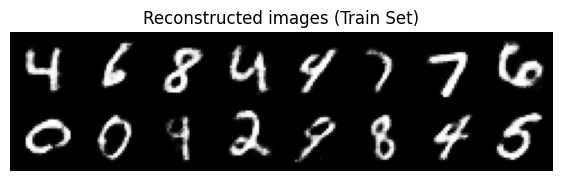

====> Test set loss: -99.8735


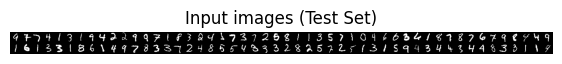

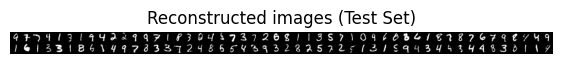

====> Epoch: 22 Average loss: -91.3396


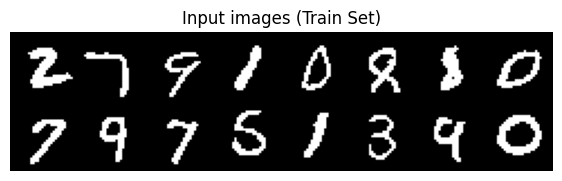

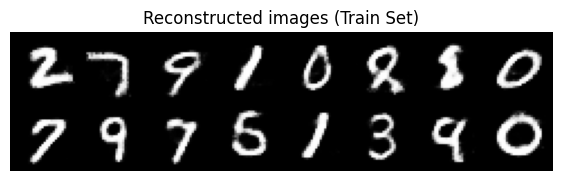

====> Test set loss: -99.9996


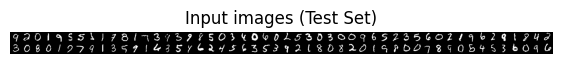

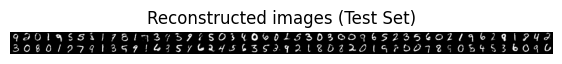

====> Epoch: 23 Average loss: -90.9557


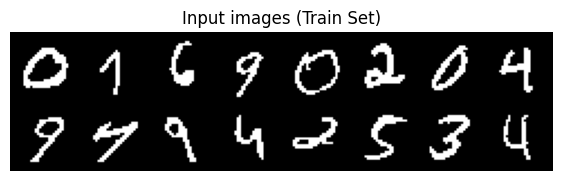

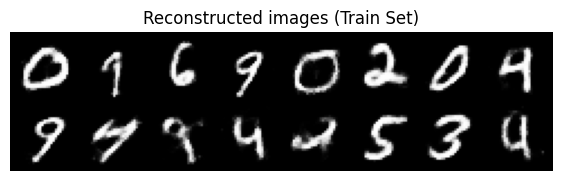

====> Test set loss: -100.5680


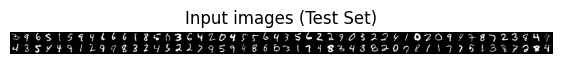

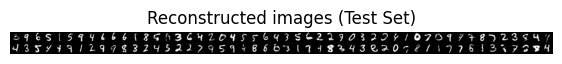

====> Epoch: 24 Average loss: -90.5428


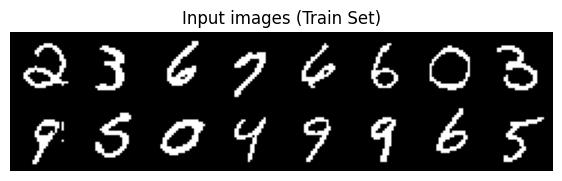

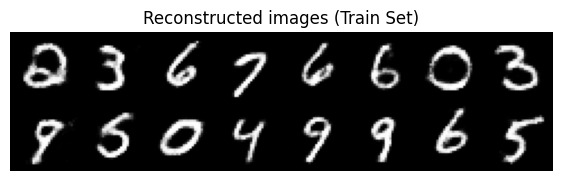

====> Test set loss: -99.9076


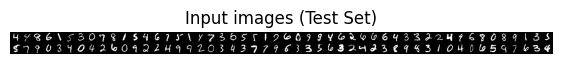

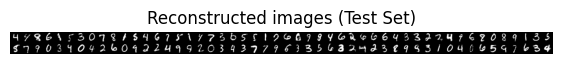

====> Epoch: 25 Average loss: -90.5349


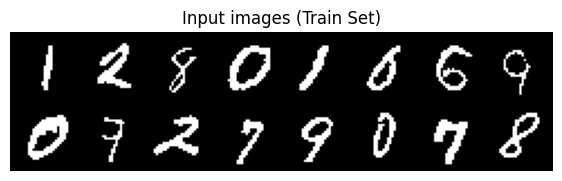

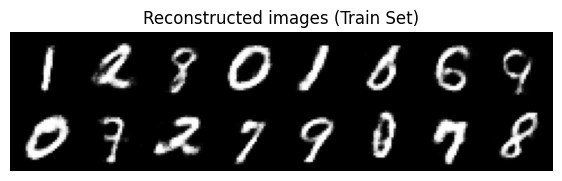

====> Test set loss: -101.1910


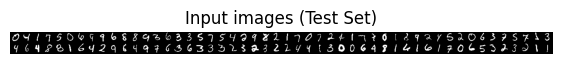

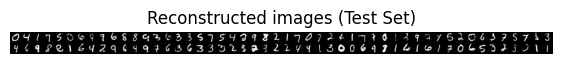

====> Epoch: 26 Average loss: -90.2644


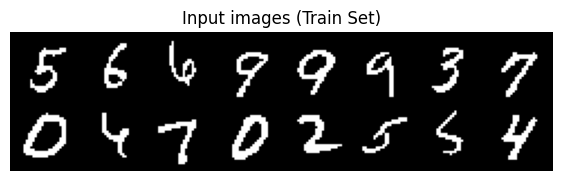

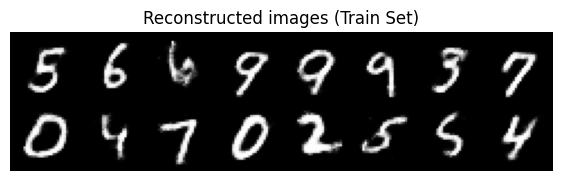

====> Test set loss: -100.2946


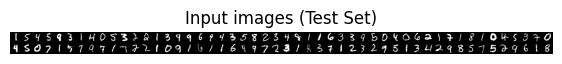

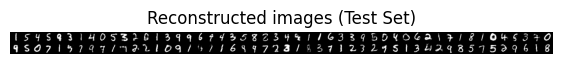

====> Epoch: 27 Average loss: -89.8056


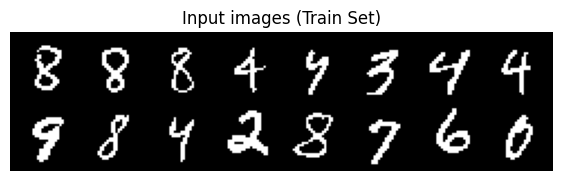

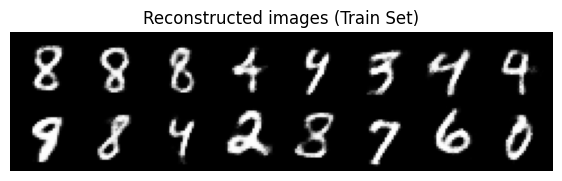

====> Test set loss: -99.5008


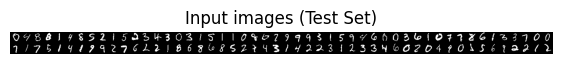

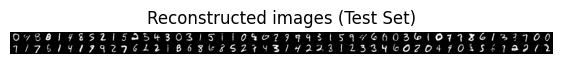

====> Epoch: 28 Average loss: -89.6267


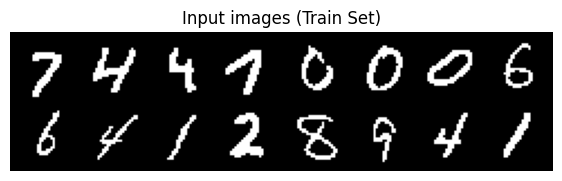

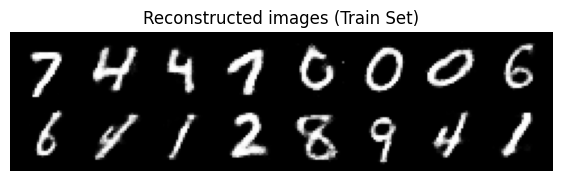

====> Test set loss: -99.7050


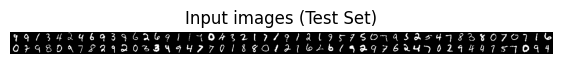

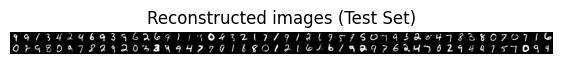

====> Epoch: 29 Average loss: -89.5255


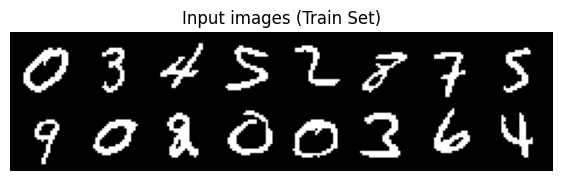

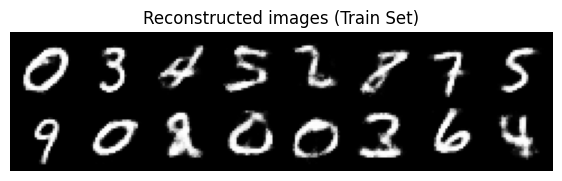

====> Test set loss: -99.9675


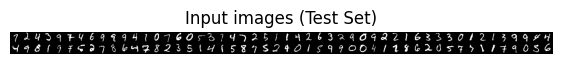

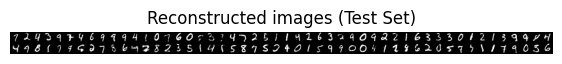

In [14]:
count=0
err_l, kld_l, n_wu, testl, update = [], [], [], [], []
for epoch in range(30):

    train_loss = 0
    for batch_idx, (data, _) in enumerate(trainloader):
        model.train()
        data = data.to(device)
        bsize = data.shape[0]
        recon_batch, mu, std = model(data)
        loss, err, kld = loss_function(recon_batch, data, mu, std)
        loss.backward()
        train_loss += err.item() + kld.item()
        optimizer.step()
        optimizer.zero_grad()
        err_l.append(err.item()/bsize)
        kld_l.append(kld.item()/bsize)
        count+=1
        n_wu.append(count)

        if (count%100 == 0): # Validating every 100 weight updates
          model.eval()
          a, _ = next(iter(testloader))
          a = a.cuda()
          trecon, tmu, tstd = model(a)
          tloss, terr, tkld = loss_function(trecon, a, tmu, tstd)
          testl.append(terr/100)
          update.append(count)

    scheduler.step(train_loss / len(trainloader.dataset))
    train_loss /= len(trainloader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss))

    show_images_grid(data, title=f'Input images (Train Set)')
    show_images_grid(recon_batch.view(data.shape[0], 28, 28), title=f'Reconstructed images (Train Set)')


    model.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in testloader:
            data = data.to(device)
            recon, mu, std = model(data)
            loss, err, kld = loss_function(recon, data, mu, std)
            test_loss += err + kld

    test_loss /= len(testloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

    show_images_grid(data, title=f'Input images (Test Set)')
    show_images_grid(recon.view(data.shape[0], 28, 28), title=f'Reconstructed images (Test Set)')

#Saving the Model

In [16]:
torch.save(model.state_dict(), 'VAE-model.pth')

#Plotting the first and second term of ELBO as a function of weight updates

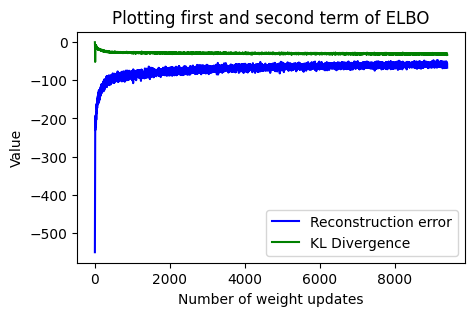

In [15]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(n_wu, err_l, 'b', label='Reconstruction error')
plt.plot(n_wu, kld_l, 'g', label='KL Divergence')
plt.title('Plotting first and second term of ELBO')
plt.xlabel('Number of weight updates')
plt.ylabel('Value')
plt.legend()

#Calculating the total model parameters



In [17]:
def count_total_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [18]:
total_params = count_total_parameters(model)
total_params

652824

#Visualize latent space

In [18]:
def visualize_latent_space(model, data_loader, device, method='TSNE', num_samples=1000):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for i, (data, label) in enumerate(data_loader):
          if len(latents) > num_samples:
            break

          data = data.view(-1, 784)
          mu, _ = model.encoder(data.to(device))
          latents.append(mu.cpu())
          labels.append(label.cpu())

    latents = torch.cat(latents, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    assert method in ['TSNE', 'UMAP'], 'method should be TSNE or UMAP'
    if method == 'TSNE':
        tsne = TSNE(n_components=2, verbose=1)
        tsne_results = tsne.fit_transform(latents)
        fig = px.scatter(tsne_results, x=0, y=1, color=labels, labels={'color': 'label'})
        fig.update_layout(title='VAE Latent Space with TSNE',
                          width=600,
                          height=600)
    elif method == 'UMAP':
        reducer = umap.UMAP()
        embedding = reducer.fit_transform(latents)
        fig = px.scatter(embedding, x=0, y=1, color=labels, labels={'color': 'label'})

        fig.update_layout(title='VAE Latent Space with UMAP',
                          width=600,
                          height=600
                          )

    fig.show()

## TSNE

In [19]:
visualize_latent_space(model, trainloader, device=device, method='TSNE', num_samples=1000)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 0.942s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.449242
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.671730
[t-SNE] KL divergence after 1000 iterations: 1.929327


## UMAP

In [20]:
visualize_latent_space(model, trainloader, device=device, method='UMAP', num_samples=1000)

# Sampling

## Posterior sampling (from given input image)

In [30]:
def posterior_sampling(model, data_loader, n_samples=25):
  model.eval()
  images, _ = next(iter(data_loader))
  images = images[:n_samples]
  with torch.no_grad():
    _, mu, std = model(images.to(device))
    std = torch.exp(0.5*std)
    encoding_dist = Normal(mu, std)
    input_sample=encoding_dist.sample()
    recon_images = model.decoder(input_sample)
    show_images_grid(images, title=f'input samples')
    show_images_grid(recon_images.view(n_samples, 28, 28), title=f'generated posterior samples')

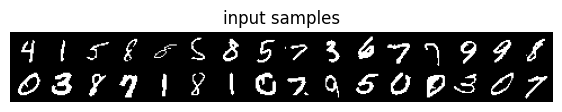

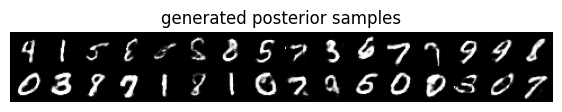

In [31]:
posterior_sampling(model, trainloader, n_samples=32)

##Prior Sampling (From a Random Latent Space Vector)

Synthesizing MNIST images from a Standard Gaussian Distribution

In [28]:
def prior_sampling(model, decoder_dim=20, n_samples = 25):
  model.eval()
  input_sample=torch.randn(n_samples, decoder_dim).to(device)
  with torch.no_grad():
    sampled_images = model.decoder(input_sample)
  show_images_grid(sampled_images.view(n_samples, 28, 28), title=f'generated prior samples')

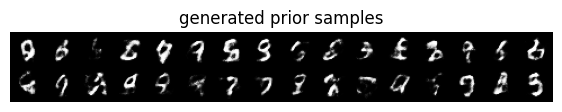

In [29]:
decoder_input_dim = 20
prior_sampling(model, decoder_input_dim, n_samples=32)

#Loading the Saved Model

In [26]:
model = VAE()  # Reinitialize the model architecture
model.load_state_dict(torch.load('VAE-model.pth'))
model = model.to(device)

#Calculate the FID score based

In [15]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from scipy import linalg
import numpy as np
from tqdm import tqdm

In [16]:
def get_inception_model():
    inception = torchvision.models.inception_v3(pretrained=True)
    inception.eval()
    return inception

In [17]:
def extract_features(model, dataloader, device):
    features = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            if isinstance(batch, (tuple, list)):
                # If batch is a tuple or list, assume the first element is the images
                images = batch[0]
            elif isinstance(batch, torch.Tensor):
                # If batch is already a tensor, use it directly
                images = batch
            else:
                raise TypeError(f"Unexpected batch type: {type(batch)}")


            if len(images.shape) == 2:     # Add a channel dimension if it's missing

                images = images.view(images.shape[0], 28, 28)
                images = images.unsqueeze(1)  # Convert to [num_images, 1, w, h]

            images = images.to(device)

            # Ensure images are the right size and format for InceptionV3 (3, 299, 299)
            if images.shape[1] == 1:  # If grayscale
                images = images.repeat(1, 3, 1, 1)  # Repeat the channel 3 times
            elif images.shape[1] != 3:
                raise ValueError(f"Unexpected number of channels: {images.shape[1]}")

            images = torch.nn.functional.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)

            feat = model(images)[0].view(images.shape[0], -1)
            features.append(feat.cpu().numpy())
    return np.concatenate(features)

In [18]:
def calculate_fid(real_features, generated_features):
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)

    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = linalg.sqrtm(sigma1.dot(sigma2))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2*covmean)
    return fid

In [19]:
# Set up data transformations
transform_inception = transforms.Compose([
    transforms.Resize((299, 299)),  # Inception v3 expects 299x299 images
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load real MNIST data
real_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_inception)

In [20]:
# Get Inception model
inception_model = get_inception_model().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
def generate_images(model, num_samples, decoder_dim, batch_size, device, seed):
    set_seed(seed)
    generated_images = []
    model.eval()
    with torch.no_grad():
        for _ in range(num_samples // batch_size + 1):
            z = torch.randn(batch_size, decoder_dim).to(device)
            generated_batch = model.decoder(z)
            generated_images.append(generated_batch)
    return torch.cat(generated_images)[:num_samples]

In [22]:
def generate_real_features(real_dataset, inception_model, batch_size, device):

    real_dataloader = DataLoader(real_dataset, batch_size=batch_size, shuffle=True)
    real_features = extract_features(inception_model, real_dataloader, device)

    return real_features

In [23]:
batch_size = 40
real_features = generate_real_features(real_dataset, inception_model, batch_size, device)

100%|██████████| 1500/1500 [04:57<00:00,  5.03it/s]


In [24]:
def calculate_fid_score(model, real_features, num_samples, decoder_dim, batch_size, device, seed):
    generated_images = generate_images(model, num_samples, decoder_dim, batch_size, device, seed)
    generated_dataset = torch.utils.data.TensorDataset(generated_images)
    generated_dataloader = DataLoader(generated_dataset, batch_size=batch_size, shuffle=False)
    generated_features = extract_features(inception_model, generated_dataloader, device)

    return calculate_fid(real_features, generated_features)

In [32]:
decoder_dim = 20
num_samples = 20000
seeds = [42, 123, 456, 789, 101112]  # Fixed seeds for reproducibility


# For each model you want to evaluate:
fid_scores = []
for seed in seeds:
    fid_score = calculate_fid_score(model, real_features, num_samples, decoder_dim, batch_size, device, seed)
    fid_scores.append(fid_score)

average_fid = np.mean(fid_scores)
std_fid = np.std(fid_scores)

print(f"Average FID Score: {average_fid:.2f} ± {std_fid:.2f}")

100%|██████████| 500/500 [01:15<00:00,  6.63it/s]


Average FID Score: 1.22 ± 0.03
